<a href="https://colab.research.google.com/github/prathamchintamani/neuralnets/blob/main/fashionMNIST_cnn_model0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [45]:
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [46]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [47]:
from torch.utils.data import DataLoader


In [48]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [49]:
image, label = train_data[60]

In [50]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [51]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

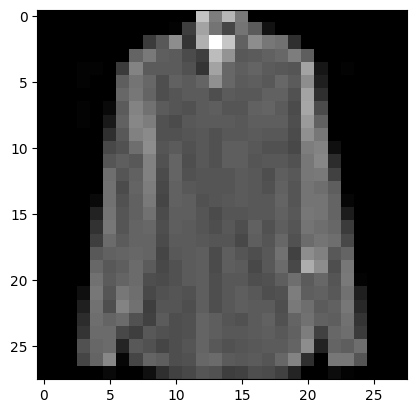

In [52]:
plt.imshow(train_features_batch[0].squeeze(),cmap = "gray")

In [53]:
flatten_model = nn.Flatten()

In [54]:
class visionmodel0(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1), #<- Change in_channels to 1
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=7 * 7 * 10, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10),
            nn.LogSoftmax(1)
        )
        self.output = self.stack

    def forward(self,x:torch.Tensor):
        return self.output(x)

In [55]:
model0 = visionmodel0().to(device)

In [56]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [58]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [59]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.63416 | Train accuracy: 76.00%
Test loss: 0.40785 | Test accuracy: 84.89%

Epoch: 1
---------
Train loss: 0.35777 | Train accuracy: 86.66%
Test loss: 0.33184 | Test accuracy: 87.82%

Epoch: 2
---------
Train loss: 0.30448 | Train accuracy: 88.61%
Test loss: 0.32253 | Test accuracy: 87.79%

Epoch: 3
---------
Train loss: 0.27439 | Train accuracy: 89.67%
Test loss: 0.29276 | Test accuracy: 89.06%

Epoch: 4
---------
Train loss: 0.25382 | Train accuracy: 90.46%
Test loss: 0.27347 | Test accuracy: 89.91%

Epoch: 5
---------
Train loss: 0.23672 | Train accuracy: 91.14%
Test loss: 0.27676 | Test accuracy: 89.64%

Epoch: 6
---------
Train loss: 0.22259 | Train accuracy: 91.63%
Test loss: 0.26718 | Test accuracy: 89.94%

Epoch: 7
---------
Train loss: 0.21116 | Train accuracy: 92.03%
Test loss: 0.24574 | Test accuracy: 90.97%

Epoch: 8
---------
Train loss: 0.20137 | Train accuracy: 92.42%
Test loss: 0.27133 | Test accuracy: 90.69%

Epoch: 9
---------
Train los